# Models and Evaluation

In [2763]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

USE_PURE_DATA = False
TRAIN_DATA_FILE = 'pure_data.csv' if USE_PURE_DATA else 'data.csv'

train_data = pd.read_csv('../assets/final/' + TRAIN_DATA_FILE)
test_data = pd.read_csv('../assets/final/kaggleData.csv')

print(train_data.shape)
print(test_data.shape)

(328, 11)
(354, 11)


In [2764]:
def get_features(df):
    return df.drop('paid', axis=1)
def get_target(df):
    return df.drop(df.columns.difference(['paid']), axis=1)

results = {}

### Split data

In [2765]:
def structure_data():
    ids_train = train_data['loan_id']
    ids_test = test_data['loan_id']

    train_data.drop(['loan_id'], axis=1, inplace=True)
    test_data.drop(['loan_id'], axis=1, inplace=True)

    train_features = get_features(train_data)
    train_target = get_target(train_data)
    test_features = get_features(test_data)
    test_target = get_target(test_data)

    return train_features, test_features, train_target, test_target, ids_train, ids_test


In [2766]:
_X_train, _X_test, _y_train, _y_test, ids_train, ids_test = structure_data()

print('\nTrain data shape: ', _X_train.shape)
print('\nTest data shape: ', _X_test.shape)
print('\nTrain shape:',_y_train.shape)
print('\nTest shape:',_y_test.shape)



Train data shape:  (328, 9)

Test data shape:  (354, 9)

Train shape: (328, 1)

Test shape: (354, 1)


### Resampling

In [2767]:
def oversample(X_train, y_train):
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=1, sampling_strategy=1.0)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    return X_train, y_train

In [2768]:
_smote_X_train, _smote_y_train = oversample(_X_train, _y_train)

print('\nTrain data shape: ', _smote_X_train.shape)
print('\nTrain shape:',_smote_y_train.shape)



Train data shape:  (564, 9)

Train shape: (564, 1)


### Algorithms

In [2769]:
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold, StratifiedKFold

k = 5
kr = 3
cv = RepeatedStratifiedKFold(n_splits=k, n_repeats=kr, random_state=0)

scoring = {"accuracy": "accuracy",
           "precision": "precision",
           "recall": "recall",
           "f1": "f1",
           "roc_auc": "roc_auc"}

In [2770]:
import datetime    

# Trains a specific Model
def add_model(name, model, use_smote=False):
    x_fit_data = _smote_X_train.copy() if use_smote else _X_train.copy()
    y_fit_data = _smote_y_train if use_smote else _y_train

    X_test = _X_test.copy()

    start = datetime.datetime.now()
    
    model.fit(x_fit_data, np.ravel(y_fit_data.values))

    # Folding data and fitting. This overwrites previous results and by some magic gives better results :)
    """ skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)
    for train_index, test_index in skf.split(x_fit_data, y_fit_data):
        #print("TRAIN:", x_fit_data.iloc[train_index], "TEST:", y_fit_data.iloc[train_index].values)
        model.fit(x_fit_data.iloc[train_index], np.ravel(y_fit_data.iloc[train_index].values)) """
        
    end = datetime.datetime.now()

    results[name] = {'model': model,
                    'X_test': X_test, 
                    'fit_time': (end - start).microseconds / 1000 # time difference in milliseconds
                    }

In [2771]:
USE_SMOTE = False

In [2772]:
from sklearn.tree import DecisionTreeClassifier
add_model('dtc',
    DecisionTreeClassifier(),
    use_smote=USE_SMOTE
)

In [2773]:
from sklearn.neighbors import KNeighborsClassifier
add_model('knn',
    KNeighborsClassifier(),
    use_smote=USE_SMOTE
)

In [2774]:
from sklearn.neural_network import MLPClassifier
add_model('mlp',
    MLPClassifier(),
    use_smote=USE_SMOTE
)

In [2775]:
from sklearn.naive_bayes import GaussianNB
add_model('gnb',
    GaussianNB(),
    use_smote=USE_SMOTE
)

In [2776]:
from sklearn.svm import SVC
add_model('svc',
    SVC(probability=True),
    use_smote=USE_SMOTE
)

In [2777]:
from sklearn.ensemble import RandomForestClassifier

add_model('rf',
    RandomForestClassifier(criterion='entropy', max_depth=6, max_features='sqrt', n_estimators=150),#criterion='entropy', max_depth=3, max_features='sqrt', n_estimators=150),
    use_smote=USE_SMOTE
)

In [2778]:
from sklearn.linear_model import LogisticRegression

add_model('lr',
    LogisticRegression(),
    use_smote=USE_SMOTE
)

## Prediction

In [2779]:
def predict(name):
    result = results[name]
    pred = result['model'].predict(result['X_test'])
    result['test_pred'] = pred

for name in results.keys():
    # Predict paid column on test data
    predict(name)

In [2780]:
def predict_proba(name):
    result = results[name]
    proba = result['model'].predict_proba(result['X_test'])
    result['test_pred_prob'] = proba

for name in results.keys():
    # Predict paid column on test data (Probability)
    predict_proba(name)

In [2781]:
# Check result object
'''
test_pred -> Prediction of paid column on test data
trainpred -> Prediction of paid column on train data

test_pred_prob -> Prediction of Probability of paid column on test data
trainpred_prob -> Prediction of Probability of paid column on train data
'''
results

{'dtc': {'model': DecisionTreeClassifier(),
  'X_test':      is_co-owned  gender  age  amount  payments  balance_min  a_avg_salary  \
  0              0       1    1   93960      1566        800.0          8390   
  1              0       0    2  260640      7240       -718.6          8620   
  2              0       0    3  232560      4845        200.0         10045   
  3              1       0    2  221880      3698       1000.0          8899   
  4              0       1    3   38520      3210        900.0          8388   
  ..           ...     ...  ...     ...       ...          ...           ...   
  349            0       0    2  352704      7348        800.0          9104   
  350            0       1    2   52512      4376       1000.0          8743   
  351            0       1    1  139488      5812       1100.0          8980   
  352            0       1    2   55632      2318        500.0         10177   
  353            0       0    2  240900      4015        700.0    

### Check Prediction Results

In [2782]:
used_ml_model = 'rf'

In [2783]:
print("ML Model analyzed: ", used_ml_model)
print(results[used_ml_model]['test_pred_prob'])

ML Model analyzed:  rf
[[0.06562948 0.93437052]
 [0.89130591 0.10869409]
 [0.21256372 0.78743628]
 [0.01266088 0.98733912]
 [0.37872316 0.62127684]
 [0.10495141 0.89504859]
 [0.11089038 0.88910962]
 [0.09059861 0.90940139]
 [0.08285687 0.91714313]
 [0.13347705 0.86652295]
 [0.12043652 0.87956348]
 [0.09686933 0.90313067]
 [0.11945614 0.88054386]
 [0.14572688 0.85427312]
 [0.08132298 0.91867702]
 [0.02761543 0.97238457]
 [0.14502046 0.85497954]
 [0.07158602 0.92841398]
 [0.11551804 0.88448196]
 [0.11426509 0.88573491]
 [0.15900526 0.84099474]
 [0.04848578 0.95151422]
 [0.84171772 0.15828228]
 [0.0432121  0.9567879 ]
 [0.01920527 0.98079473]
 [0.17168108 0.82831892]
 [0.21160283 0.78839717]
 [0.15542257 0.84457743]
 [0.21078483 0.78921517]
 [0.21078483 0.78921517]
 [0.10066006 0.89933994]
 [0.1781083  0.8218917 ]
 [0.09135419 0.90864581]
 [0.10232377 0.89767623]
 [0.03375236 0.96624764]
 [0.01752422 0.98247578]
 [0.18198841 0.81801159]
 [0.12198495 0.87801505]
 [0.14645534 0.85354466]
 [

### Save the predictions results

In [2784]:
import os

RES_PATH = '../assets/results'
if not os.path.exists(RES_PATH):
  os.mkdir(RES_PATH)

res = {'Id': ids_test.values, 'Predicted': results[used_ml_model]['test_pred_prob'][:,0]}

df = pd.DataFrame(data=res)
df.to_csv(RES_PATH + '/submission.csv', index=False)

df

,Id,Predicted
0,5895,0.065629
1,7122,0.891306
2,6173,0.212564
3,6142,0.012661
4,5358,0.378723
...,...,...
349,4989,0.264039
350,5221,0.163236
351,6402,0.154173
352,5346,0.128798


## Evaluate Prediction with ROC Curve

Submission score: 0.9215020576131687% (~0.92%)


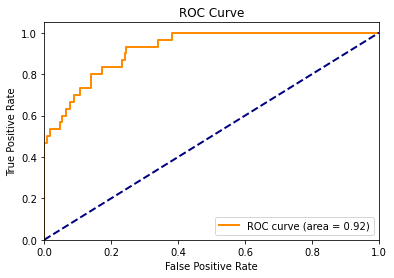

In [2785]:
import pandas as pd

SHOW_GRAPH = True

SUBMISSION_PATH = "../assets/results/submission.csv"
RESULTS_PATH = "../assets/complete_clean/loan_dev.csv"

submission_pd = pd.read_csv(SUBMISSION_PATH)
results_pd = pd.read_csv(RESULTS_PATH)
mix_pd = pd.merge(submission_pd, results_pd, left_on='Id', right_on='loan_id', how='inner')

submission_scores = mix_pd["Predicted"].values.tolist()
results = mix_pd["paid"].values.tolist()

fpr, tpr, thresholds = roc_curve(results, submission_scores, pos_label=0)
auc = auc(fpr, tpr)

print(f"Submission score: {auc}% (~{round(auc, 2)}%)")

if SHOW_GRAPH:
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


---------------------